# KTモデルでMPCを試す
- [do_mpc](https://www.do-mpc.com/en/latest/)を利用して、KTモデルでMPCを実施する例

In [1]:
import numpy as np
import do_mpc
from casadi import vertcat

import matplotlib.pyplot as plt
import matplotlib as mpl
# Customizing Matplotlib:
mpl.rcParams['font.size'] = 18
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['axes.grid'] = True

# Create model

In [2]:
model_type = 'continuous' # either 'discrete' or 'continuous'
model = do_mpc.model.Model(model_type)

## Model variables

- states : `var_type=_u`
- inputs : `var_type=_x`

In [3]:
δ = model.set_variable(var_type='_u', var_name='δ', shape=(1,1))
δ_m = model.set_variable(var_type='_x', var_name='δ_m', shape=(1,1))
r = model.set_variable(var_type='_x', var_name='r', shape=(1,1))

## Model parameters

- parameter : `var_type=_p`

In [4]:
K = model.set_variable(var_type='_p', var_name='K')
T = model.set_variable(var_type='_p', var_name='T')

## Right-hand-side equation
- 要するに微分方程式を構築する部分

In [5]:
model.set_rhs('r', 1.0 / T * (- r + K * δ ))

In [6]:
model.set_rhs('δ_m', δ - δ_m)

## Model setup

In [7]:
model.setup()

---

# Configuring the MPC controller

In [8]:
mpc = do_mpc.controller.MPC(model)

In [9]:
n_horizon = 200
t_step = 0.1
n_robust = 1 # default to 0
store_full_solution = True

setup_mpc = {
    'n_horizon': n_horizon,
    't_step': t_step,
    'n_robust': n_robust,
    'store_full_solution': store_full_solution,
}

mpc.set_param(**setup_mpc)

## Objective function

$$
C=\sum_{k=0}^{n-1}(\underbrace{l\left(x_{k}, u_{k}, z_{k}, p\right)}_{\text {lagrange term }}+\underbrace{\Delta u_{k}^{T} R \Delta u_{k}}_{\text {r-term }})+\underbrace{m\left(x_{n}\right)}_{\text {meyer term }}
$$

今回は、角速度$r$のターゲットを決めて、それに近づけるような目的関数を設定する

In [10]:
target_r = 0.00050
mterm = (r - target_r)**2
lterm = (r - target_r)**2
mpc.set_objective(mterm=mterm, lterm=lterm)
mpc.set_rterm(δ = 1e-3)

## Constraints

In [11]:
mpc.bounds['lower','_u', 'δ'] = - 30 * np.pi / 180
mpc.bounds['upper','_u', 'δ'] = 30 * np.pi / 180

## Scaling
- OCP(Optimal control problem)では、変数間のオーダーの違いによって結果が変わってしまうことが知られている
  - なんか、DNNとかと同じなんですねぇ

- この例では、デフォルトの1を設定する（設定しなくても同じ）

In [12]:
mpc.scaling['_x', 'r'] = 1

## Uncertain Parameters

- なんか、.set_p_fun() (low-level API) or .set_uncertainty_values() (high-level API)をセットしないといけない。
- 不確実性を考慮することができるみたいなので、ちょっと今回はset_uncertainty_values()を使う

In [13]:
mpc.set_uncertainty_values(
    K = 0.15 * np.array([1., 0.95, 1.05]),
    T = 80.0 * np.array([1., 0.90, 1.10]),
)

## MPC setup

In [14]:
mpc.setup()

---
# Simulator parameters

In [15]:
simulator = do_mpc.simulator.Simulator(model)

## Simulator parameters
- t_stepだけはデフォルトではなく設定しないといけない
- ここではmpcと同じ設定を使う

In [16]:
simulator.set_param(t_step = t_step)

## Uncertain parameters
- 今回は、ここでは固定値を使う
  - その時はset_p_fun()を使うらしい

In [17]:
p_template = simulator.get_p_template()

In [18]:
p_template.keys()

['default', 'K', 'T']

In [19]:
def p_fun(t_now):
    p_template['K'] = 0.15
    p_template['T'] = 80.0
    return p_template

In [20]:
simulator.set_p_fun(p_fun)

## Simulator setup

In [21]:
simulator.setup()

---
# Creating the control loop
- この時点でestimatorも作れるけど、今回はかんたんな例としてdirect-state-feedbackを想定する

## Initial condition (x0)

In [22]:
x0 = np.array([0.0, 0.0]).reshape(-1,1)
simulator.x0 = x0
mpc.x0 = x0
mpc.set_initial_guess()

## Setting up the Graphic

In [23]:
mpc_graphics = do_mpc.graphics.Graphics(mpc.data)
sim_graphics = do_mpc.graphics.Graphics(simulator.data)

In [24]:
%%capture
# We just want to create the plot and not show it right now. This "inline magic" supresses the output.
fig, ax = plt.subplots(2, sharex=True, figsize=(16,9))
fig.align_ylabels()

In [25]:
%%capture
for g in [sim_graphics, mpc_graphics]:
    g.add_line(var_type='_x', var_name='r', axis=ax[0])
    g.add_line(var_type='_u', var_name='δ', axis=ax[1])


ax[0].set_ylabel('rate_of_turn [rad/s]')
ax[1].set_ylabel('delta [rad]')
ax[1].set_xlabel('time [s]')

## Running the simulator
- u=0

In [26]:
u0 = np.zeros((1,1))
for i in range(200):
    simulator.make_step(u0)

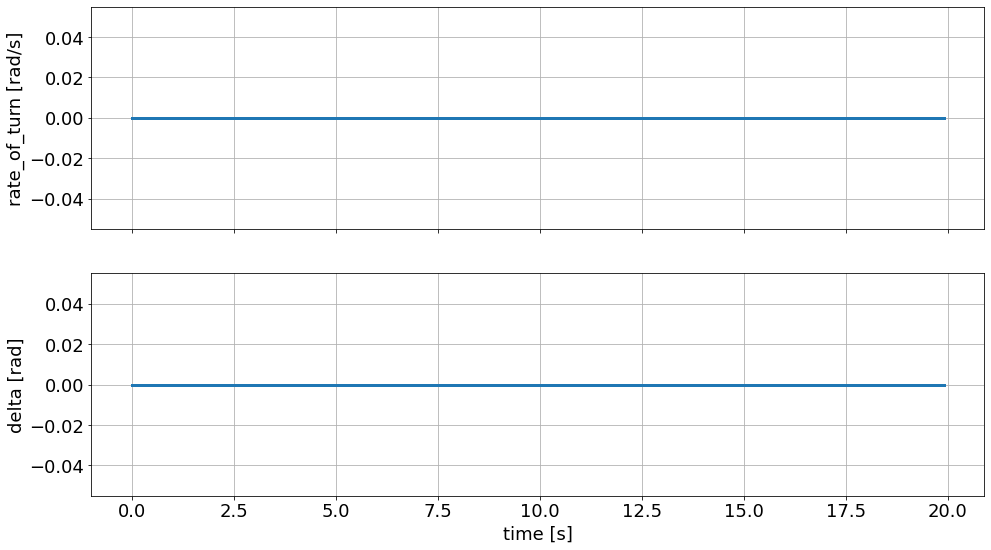

In [27]:
sim_graphics.plot_results()
# Reset the limits on all axes in graphic to show the data.
sim_graphics.reset_axes()
# Show the figure:
fig

## Running the MPC optimizer

In [28]:
u0 = mpc.make_step(mpc.x0)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:    43202
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     5384

Total number of variables............................:    16272
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1800
                     variables with only upper bounds:        0
Total number of equa

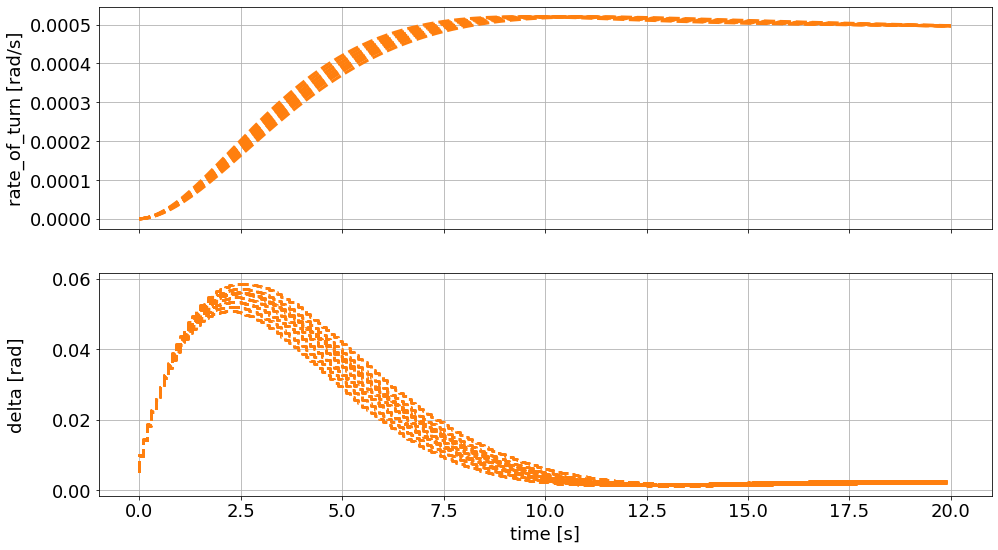

In [29]:
sim_graphics.clear()
mpc_graphics.plot_predictions()
mpc_graphics.reset_axes()
# Show the figure:
fig

## Running the control loop
- mpc optimizerでinputを得て、それをsimulatorで使うということを繰り返す

In [30]:
simulator.reset_history()
simulator.x0 = x0
mpc.reset_history()

In [31]:
%%capture
for i in range(n_horizon):
    u0 = mpc.make_step(x0)
    x0 = simulator.make_step(u0)

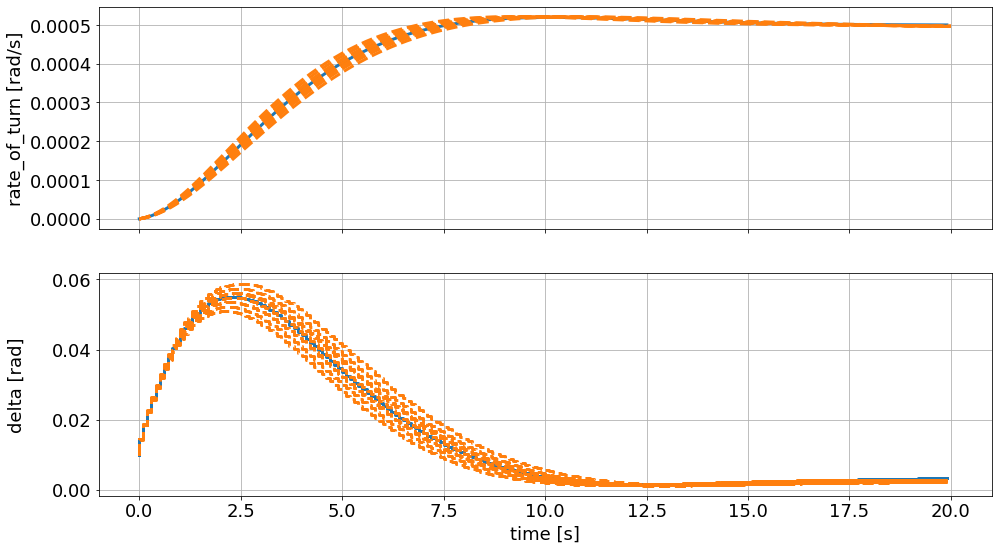

In [32]:
sim_graphics.clear()
mpc_graphics.clear()
# Plot predictions from t=0
mpc_graphics.plot_predictions(t_ind=0)
# Plot results until current time
sim_graphics.plot_results()
sim_graphics.reset_axes()
fig

---
# Data processing and visualizing by using shipmmg

In [33]:
# remove past results
!rm -rf results/

# save present result
from do_mpc.data import save_results, load_results
save_results([mpc, simulator])

In [34]:
results = load_results('./results/results.pkl')

## shipmmgを使ってデータ可視化

In [35]:
from shipmmg.ship_obj_3dof import ShipObj3dof
time_list = np.linspace(0.00, n_horizon*t_step, n_horizon)
u_list = np.full(len(time_list), 20 * (1852.0 / 3600))
v_list = np.zeros(len(time_list))
r_list = results['simulator']['_x','r'].reshape(-1)
ship_kt = ShipObj3dof(L=100, B=10)
ship_kt.load_simulation_result(time_list, u_list, v_list, r_list)
δ_list = results['simulator']['_u','δ'].reshape(-1)
ship_kt.δ = δ_list

Text(0, 0.5, 'r_vel [rad/s]')

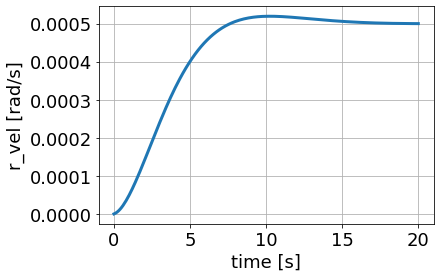

In [36]:
plt.plot(time_list, r_list)
plt.xlabel('time [s]')
plt.ylabel('r_vel [rad/s]')

# plt.plot(time_list, list(map(lambda r: r * 180 / np.pi ,r_list)))
# plt.xlabel('time [s]')
# plt.ylabel('r_vel [degree/s]')

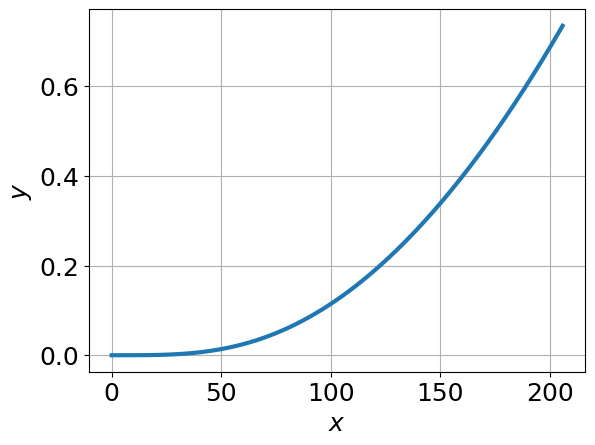

In [37]:
ship_kt.draw_xy_trajectory(aspect_equal=False)

In [38]:
ship_kt.draw_gif(save_fig_path='kt_demo.gif')